### This snippet is using the Kaggle Titanic as basic to capture codes for a basic ML model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime
import sklearn as skl
import sklearn.datasets as mldata
import matplotlib
import seaborn as sns
np.random.seed(42)
%matplotlib inline
test = pd.read_csv("D:\\William\\Jupyter\\Titanic Tableau\\test.csv")
train = pd.read_csv("D:\\William\\Jupyter\\Titanic Tableau\\train.csv")
testpt2 = pd.read_csv("D:\\William\\Jupyter\\Titanic Tableau\\gender_submission.csv")
print(test.columns, '\n')
print(testpt2.columns, '\n' )
print(train.columns, '\n')

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') 

Index(['PassengerId', 'Survived'], dtype='object') 

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') 



In [6]:
# Function 0: Union dataset

testfull = pd.merge(test, testpt2 , on= "PassengerId")
def stack_2_datasets(data1 , data1name , data2 , data2name):
    data1['file'] = data1name
    data2['file'] = data2name
    full = train.append(data1, sort=False)
    print(data1name, 'has', data1.shape ,'rows/columns')
    print(data2name, 'has', data2.shape ,'rows/columns')
    print('After combining vertically, the new data now has', full.shape,'rows/columns')
    return full 

fulltableau = stack_2_datasets(testfull,'test',train,'train')

test has (418, 13) rows/columns
train has (891, 13) rows/columns
After combining vertically, the new data now has (1309, 13) rows/columns


In [12]:
# Function 1: Seperate Datasets:
def XYsplit(data , targetvar):
    y_train = data[targetvar]
    x_train = data.loc[:, train.columns != targetvar]
    print(y_train.sample(1))
    print(x_train.sample(5))
    return y_train , x_train
y_train, x_train = XYsplit(train, 'Survived')

254    0
Name: Survived, dtype: int64
     PassengerId  Pclass                                 Name     Sex  Age  \
697          698       3     Mullens, Miss. Katherine "Katie"  female  NaN   
183          184       2            Becker, Master. Richard F    male  1.0   
184          185       3  Kink-Heilmann, Miss. Luise Gretchen  female  4.0   
388          389       3                 Sadlier, Mr. Matthew    male  NaN   
5              6       3                     Moran, Mr. James    male  NaN   

     SibSp  Parch  Ticket     Fare Cabin Embarked   file  
697      0      0   35852   7.7333   NaN        Q  train  
183      2      1  230136  39.0000    F4        S  train  
184      0      2  315153  22.0250   NaN        S  train  
388      0      0  367655   7.7292   NaN        Q  train  
5        0      0  330877   8.4583   NaN        Q  train  


In [7]:
# Function 2: Pipelining data for a quick and dirty - covering both numeric and categorical

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)
    
# Cast all numeric into select_numeric & cast all categories into select_cat & 
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
X_train = preprocess_pipeline.fit_transform(x_train)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [16]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)
X_test = preprocess_pipeline.transform(test)
y_pred = svm_clf.predict(X_test)

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

In [15]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

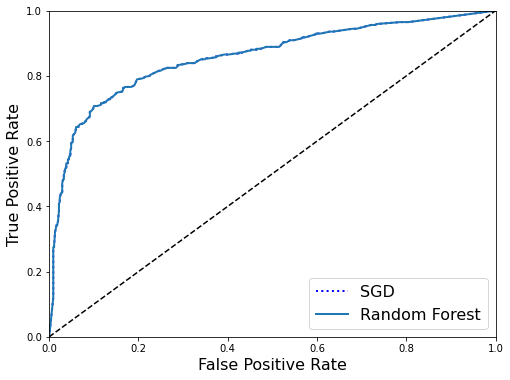

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
model = RandomForestClassifier(n_estimators=100, #how many decision trees to build
                                    random_state=42)
y_probas_forest = cross_val_predict(model, X_train , y_train, cv=10 ,method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train,y_scores_forest)
def plot_roc_curve(fpr, tpr, label=None):
        plt.plot(fpr, tpr, linewidth=2, label=label)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.axis([0, 1, 0, 1])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
plt.figure(figsize=(8, 6))
plt.plot(fpr_forest, tpr_forest, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the numbe

Logreg: 0.799126 (0.031383)
NN: 0.718390 (0.043113)
DT: 0.787903 (0.026582)


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


RF: 0.810362 (0.032867)
NB: 0.785680 (0.023826)


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


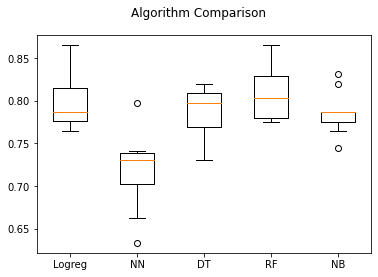

In [50]:
randomseed = 1234
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import model_selection

models = {
    "Logreg": LogisticRegression(solver='lbfgs'),
    "NN": KNeighborsClassifier(),
    #"LinearSVM": SVC(probability=True, kernel='linear'), #class_weight='balanced'
    #"GBC": GradientBoostingClassifier(),
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "NB": GaussianNB(),
}
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
seed = 1234

for m in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(models[m], X_train , y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(m)
	msg = "%s: %f (%f)" % (m, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [51]:
dict_classifiers = {
    "Logreg": LogisticRegression(solver='lbfgs'),
    "KNN": KNeighborsClassifier(),
    "LinearSVM": SVC(probability=True, kernel='linear'), #class_weight='balanced'
    "GBC": GradientBoostingClassifier(),
    "DT": tree.DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "NB": GaussianNB(),
}
def displaymetrics(code: list, models: list, X_train: np.array, X_test: np.array, X: pd.DataFrame):
    for model in models:  # or for i in range(0, len(models)):
        y_score = model.fit(X_train, y_train).decision_function(X_test)
        # or y_score = models[i].fit(X_train, y_train).decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        # etc etc
        

NameError: name 'tree' is not defined